Load data

In [1]:
import rosbag
import sensor_msgs.point_cloud2

import numpy as np

# livox mid360 lidar undistorted using fast-lio
bag_name = "/home/harry7557558/2024-06-08-16-51-41.bag"

bag = rosbag.Bag(bag_name)

all_clouds = []
for topic, msg, msg_t in bag.read_messages():
    if topic != "/cloud_train_undistorted":
        continue
    points = sensor_msgs.point_cloud2.read_points(
            msg, field_names=("x", "y", "z", "curvature"),
            skip_nans=True)
    points = np.array([*points])
    positions = points[:, :3]
    times = points[:, 3] / 1000
    all_clouds.append((positions, times))

print(len(all_clouds), 'clouds')

106 clouds


Apply fake distortion

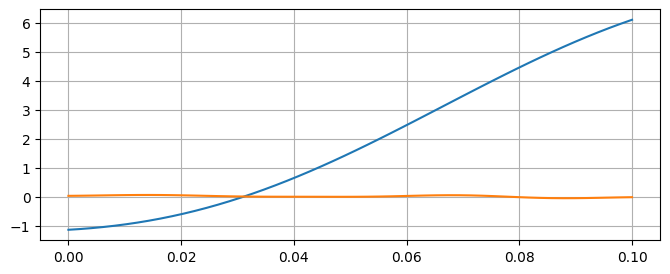

In [10]:
def random_signal(ts, n, amp, freq, decay):
    dt = np.amax(ts)-np.amin(ts)
    w = freq * 2.0*np.pi/dt
    I = np.arange(n)
    A = amp * np.random.randn(n) * np.exp(-decay*I)
    T = 2.0*np.pi*np.random.random(n)
    ws = np.sum(A[:,None]*np.sin(w*np.outer(I,ts)+T[:,None]), axis=0)
    return ws

# https://www.desmos.com/calculator/e5ghr5v301
RAND_VEL = (15, 3.0, 0.05, 0.2)
RAND_TWIST = (15, 3.0, 0.05, 0.2)
RAND_POS_D = (7, 0.05, 0.65, 0.3)
RAND_POSE_D = (7, 0.05, 0.65, 0.3)

ts = np.linspace(0, 0.1)
ws1 = random_signal(ts, *RAND_VEL)
ws2 = random_signal(ts, *RAND_POS_D)

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8,3))
plt.plot(ts, ws1)
plt.plot(ts, ws2)
plt.grid()
plt.show()

In [12]:
def exp_so3(phi):
    theta = np.linalg.norm(phi, axis=1).reshape((-1,1))
    theta = np.fmax(theta, 1e-12*np.ones_like(theta))
    n = phi / theta
    nnT = np.einsum('ki,kj->kij', n, n)
    n_star = np.zeros_like(nnT)
    n_star[:,0,1] = -n[:,2]
    n_star[:,0,2] = n[:,1]
    n_star[:,1,0] = n[:,2]
    n_star[:,1,2] = -n[:,0]
    n_star[:,2,0] = -n[:,1]
    n_star[:,2,1] = n[:,0]
    I = np.eye(3).reshape((-1,3,3)).repeat(len(theta),axis=0)
    theta = theta.reshape((-1,1,1))
    R = np.cos(theta) * I + \
        (1.0-np.cos(theta)) * nnT + \
        np.sin(theta) * n_star
    if True:
        residual = np.einsum('nij,nkj->nik', R, R) - I
        assert (np.linalg.norm(residual, axis=(1,2)) < 1e-12).all()
    return R

def apply_distortion(points, times):
    times = times - np.amax(times)  # odometry starts at the end
    delta_t = np.random.rand(len(times)) * np.median(times[1:]-times[:-1])
    # print(delta_t)
    # plt.hist(times[1:]-times[:-1], bins=1000)
    # plt.xlim(0.0, 2e-5)
    # plt.show()

    # apply noise
    vel = np.array([random_signal(times, *RAND_VEL) for _ in range(3)]).T
    so3 = np.array([random_signal(times, *RAND_TWIST) for _ in range(3)]).T
    vel_p = vel + np.cross(so3, points)
    points = points - vel_p * delta_t[:,None]
    
    # apply bias distortion
    pos_d = np.array([random_signal(times, *RAND_POS_D) for _ in range(3)]).T
    so3_d = np.array([random_signal(times, *RAND_POSE_D) for _ in range(3)]).T
    points = np.einsum('kij,kj->ki', exp_so3(so3_d), points) + pos_d

    return points


pcl1, times1 = all_clouds[4]
pcl2 = apply_distortion(pcl1, times1)

%matplotlib tk
# %matplotlib inline

fig = plt.figure(figsize=(14, 14))
ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(pcl1[:,0], pcl1[:,1], pcl1[:,2], s=1)
ax1.scatter(pcl2[:,0], pcl2[:,1], pcl2[:,2], s=1)
plt.show()

Point embedding

In [13]:
all_clouds_normalized = []
for points, times in all_clouds:
    norms = np.linalg.norm(points, axis=1)
    mean_norm = np.mean(norms)
    normalized = points / mean_norm
    distorted = apply_distortion(points, times)
    distorted_normalized = distorted / mean_norm
    all_clouds_normalized.append((normalized, distorted_normalized, times, mean_norm))

In [15]:
from scipy.spatial import KDTree

NUM_NEIGHBORS = 20

data_x = []
data_y = []
for cloud_gt, cloud, times, mean_norm in all_clouds_normalized:
    times_normalized = (times-np.amin(times)) / (np.amax(times)-np.amin(times))
    tree = KDTree(cloud)
    for point_gt, point, time in zip(cloud_gt, cloud, times_normalized):
        # decomposed point
        point_norm = np.linalg.norm(point)
        point_dir = point / point_norm
        # neighbor moments
        distances, indices = tree.query(point, NUM_NEIGHBORS+1)
        displacements = cloud[indices[1:]] - point[None,:]
        disps_mean = np.mean(displacements, axis=0)
        disps_cov = np.cov(displacements.T).flatten()
        # time embedding
        time_embeddings = [time]
        for i in range(1, 4):
            time_embeddings += [np.cos(2*np.pi*i*time), np.sin(2*np.pi*i*time)]
        # x data - concatenate
        data_x.append(np.concatenate((
            point, [point_norm], point_dir,
            disps_mean, disps_cov,
            time_embeddings)))
        # y data - residual
        data_y.append(point_gt-point)
        pass
    #break

In [16]:
data_x = np.array(data_x)
data_y = np.array(data_y)
print(data_x.shape)
print(data_y.shape)

(558225, 26)
(558225, 3)


In [17]:
data_x_mean = np.mean(data_x, axis=0)
data_x_std = np.std(data_x, axis=0)
data_x_normalized = (data_x-data_x_mean) / data_x_std
print(data_x_mean)
print(data_x_std)

data_y_mean = np.mean(data_y, axis=0)
data_y_std = np.std(data_y, axis=0)
data_y_normalized = (data_y-data_y_mean) / data_y_std
print(data_y_mean)
print(data_y_std)

[ 6.23167005e-02 -1.08937844e-01  4.23768432e-01  9.99838949e-01
  1.35203288e-01  4.00753919e-02  3.91365566e-01  1.11627414e-03
  1.63158188e-03 -9.01592615e-04  2.55936755e-03 -7.74640260e-05
 -1.51960693e-04 -7.74640260e-05  2.46716272e-03 -5.81935274e-06
 -1.51960693e-04 -5.81935274e-06  2.50877034e-03  4.97845084e-01
 -1.18985748e-03  7.33920840e-03 -1.71869961e-03 -1.18095511e-03
 -3.88289208e-03 -1.06791183e-03]
[0.63151303 0.70101861 0.37815087 0.47842081 0.58607536 0.63244928
 0.28891282 0.03698481 0.03653396 0.03569025 0.0089485  0.00526756
 0.00681531 0.00526756 0.00624494 0.0044906  0.00681531 0.0044906
 0.01004198 0.28833842 0.70649787 0.70767612 0.70703697 0.70717351
 0.70754422 0.7066576 ]
[-0.00066457  0.00232525  0.00331119]
[0.0515446  0.04805294 0.05288259]


Train model

cuda
Epoch 1/40, Train Loss: 0.6707, Val Loss: 0.6498
Epoch 2/40, Train Loss: 0.6346, Val Loss: 0.6257
Epoch 3/40, Train Loss: 0.6145, Val Loss: 0.6094
Epoch 4/40, Train Loss: 0.5994, Val Loss: 0.6004
Epoch 5/40, Train Loss: 0.5878, Val Loss: 0.5894
Epoch 6/40, Train Loss: 0.5791, Val Loss: 0.5827
Epoch 7/40, Train Loss: 0.5716, Val Loss: 0.5779
Epoch 8/40, Train Loss: 0.5654, Val Loss: 0.5728
Epoch 9/40, Train Loss: 0.5598, Val Loss: 0.5684
Epoch 10/40, Train Loss: 0.5553, Val Loss: 0.5655
Epoch 11/40, Train Loss: 0.5505, Val Loss: 0.5630
Epoch 12/40, Train Loss: 0.5476, Val Loss: 0.5600
Epoch 13/40, Train Loss: 0.5441, Val Loss: 0.5572
Epoch 14/40, Train Loss: 0.5408, Val Loss: 0.5532
Epoch 15/40, Train Loss: 0.5384, Val Loss: 0.5523
Epoch 16/40, Train Loss: 0.5356, Val Loss: 0.5501
Epoch 17/40, Train Loss: 0.5332, Val Loss: 0.5501
Epoch 18/40, Train Loss: 0.5317, Val Loss: 0.5474
Epoch 19/40, Train Loss: 0.5296, Val Loss: 0.5449
Epoch 20/40, Train Loss: 0.5280, Val Loss: 0.5442
Epoc

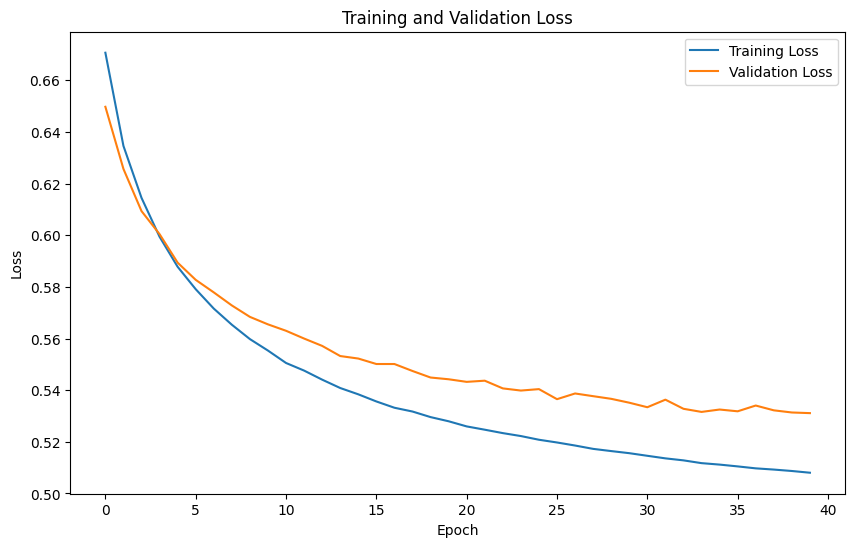

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Convert NumPy arrays to PyTorch tensors
x_tensor = torch.from_numpy(data_x_normalized).float().to(device)
y_tensor = torch.from_numpy(data_y_normalized).float().to(device)

# Split the data into training and validation sets
train_size = int(0.8 * len(x_tensor))
val_size = len(x_tensor) - train_size
train_data, val_data = torch.utils.data.random_split(TensorDataset(x_tensor, y_tensor), [train_size, val_size])

# Create data loaders
batch_size = 256
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        y = self.fc4(x)
        return y

# Instantiate the model
input_size = x_tensor.shape[1]
hidden_size = 128
output_size = y_tensor.shape[1]
model = MLP(input_size, hidden_size, output_size).to(device)

# Define the loss function and optimizer
criterion = nn.L1Loss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.002)

# Training loop
num_epochs = 40
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0

    # Training
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    # Validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_data)
    val_loss /= len(val_data)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Plot the training curve
%matplotlib inline
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Evaluate model

In [23]:
def undistort_cloud(cloud, times):
    data_x = []
    times_normalized = (times-np.amin(times)) / (np.amax(times)-np.amin(times))
    tree = KDTree(cloud)
    for point, time in zip(cloud, times_normalized):
        # decomposed point
        point_norm = np.linalg.norm(point)
        point_dir = point / point_norm
        # neighbor moments
        distances, indices = tree.query(point, NUM_NEIGHBORS+1)
        displacements = cloud[indices[1:]] - point[None,:]
        disps_mean = np.mean(displacements, axis=0)
        disps_cov = np.cov(displacements.T).flatten()
        # time embedding
        time_embeddings = [time]
        for i in range(1, 4):
            time_embeddings += [np.cos(2*np.pi*i*time), np.sin(2*np.pi*i*time)]
        # x data - concatenate
        data_x.append(np.concatenate((
            point, [point_norm], point_dir,
            disps_mean, disps_cov,
            time_embeddings)))
    data_x = np.array(data_x)
    
    data_x_normalized = (data_x-data_x_mean)/data_x_std
    x_tensor = torch.from_numpy(data_x_normalized).float().to(device)
    with torch.no_grad():
        y_tensor = model(x_tensor)
    data_y_normalized = y_tensor.cpu().numpy()
    data_y = data_y_normalized*data_y_std+data_y_mean
    return cloud + data_y


pcl1, times1 = all_clouds[4]
pcl2 = apply_distortion(pcl1, times1)
pcl3 = undistort_cloud(pcl2, times1)

%matplotlib tk

fig = plt.figure(figsize=(16, 10))
ax1 = fig.add_subplot(121, projection='3d', proj_type='ortho')
ax2 = fig.add_subplot(122, projection='3d', proj_type='ortho')
# ax1.scatter(pcl1[:,0], pcl1[:,1], pcl1[:,2], s=0.2)
ax1.scatter(pcl2[:,0], pcl2[:,1], pcl2[:,2], s=0.2)
ax2.scatter(pcl3[:,0], pcl3[:,1], pcl3[:,2], s=0.2)
plt.show()